In [6]:
import pandas as pd
from pandas_profiling import ProfileReport
import json
import numpy as np

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

jobs = pd.read_csv(r"C:\Users\Juan.VELIZ\OneDrive\Github\Linkedin\Datasets\linkedin-jobs.csv")


In [7]:
# Extract from column "criteria" each value and take it to its own column
def extract_criteria(x, crit):
    trans = {
        "Seniority level": "Nivel de antigüedad",
        "Employment type": "Tipo de empleo",
        "Job function": "Función laboral",
        "Industries": "Sectores",
        "Nível de experiência": "Nivel de antigüedad",
        "Tipo de emprego": "Tipo de empleo",
        "Função": "Función laboral",
        "Setores": "Sectores"
        }

    for orig, dest in trans.items():
        x = x.replace(orig, dest)

    d = json.loads(x.replace("\'", "\""))

    exists = []
    for item in d:
        exists.append(crit in item in d)

    if bool(True in exists):
        pos = exists.index(True)
        return d[pos][crit]
    
jobs["seniority_level"] = jobs["criteria"].apply(extract_criteria, crit="Nivel de antigüedad")
jobs["employment_type"] = jobs["criteria"].apply(extract_criteria, crit="Tipo de empleo")
jobs["job_function"] = jobs["criteria"].apply(extract_criteria, crit="Función laboral")
jobs["industries"] = jobs["criteria"].apply(extract_criteria, crit="Sectores")

jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1792 entries, 0 to 1791
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          1792 non-null   object
 1   title            1792 non-null   object
 2   company          1792 non-null   object
 3   location         1792 non-null   object
 4   onsite_remote    1792 non-null   int64 
 5   salary           78 non-null     object
 6   description      1734 non-null   object
 7   criteria         1792 non-null   object
 8   posted_date      1792 non-null   object
 9   link             1792 non-null   object
 10  seniority_level  1619 non-null   object
 11  employment_type  1725 non-null   object
 12  job_function     1619 non-null   object
 13  industries       1613 non-null   object
dtypes: int64(1), object(13)
memory usage: 196.1+ KB


In [8]:
jobs = jobs.drop(columns=["location", "criteria", "salary"])

jobs.drop_duplicates(subset=jobs.drop(columns="link").columns, inplace=True)

jobs["description"].replace("N/A", None, inplace=True)
jobs = jobs.dropna(axis=0, subset="description")

# Keep only relevant job titles
jobs = jobs.loc[jobs["title"].str.contains("Analyst|Analista|Data|Datos|Dados", case=False, regex=True)]

jobs.reset_index(drop=True, inplace=True)

jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1126 entries, 0 to 1125
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          1126 non-null   object
 1   title            1126 non-null   object
 2   company          1126 non-null   object
 3   onsite_remote    1126 non-null   int64 
 4   description      1126 non-null   object
 5   posted_date      1126 non-null   object
 6   link             1126 non-null   object
 7   seniority_level  1066 non-null   object
 8   employment_type  1117 non-null   object
 9   job_function     1066 non-null   object
 10  industries       1061 non-null   object
dtypes: int64(1), object(10)
memory usage: 96.9+ KB


In [9]:
# Define skills to be analyzed, and how can they appear in text
tech_stack_dicts = {
    "Visualization": {
        "Power BI": ["Power BI","PowerBI"],
        "Microstrategy": "Microstrategy",
        "Tableau": "Tableau",
        "Qlik Sense": ["Qlik Sense", "Qliksense", "Qlikview", "Qlik View"],
        "Klipfolio": "Klipfolio",
        "Looker": "Looker",
        "Zoho": "Zoho",
        "Domo": "Domo"
        },
    "ETL" : {
        "Excel": ["Excel ", "Excel,"],
        "Python": "Python",
        "Bash": "Bash",
        "Perl": "Perl",
        "PySpark": "PySpark"
        },
    "Data Base": {
        "MySQL": "MySQL",
        "SQL": ["SQL, ", " SQL "],
        "SQLite": "SQLite",
        "PostgreSQL": "Postgre",
        "MariaDB": "MariaDB",
        "Redis": "Redis",
        "MongoDB": "MongoDB",
        "Oracle": "Oracle",
        "Firebase": "Firebase",
        "Elasticsearch": "Elasticsearch",
        "Cassandra": "Cassandra",
        "DynamoDB": "DynamoDB",
        "IBM Db2": "Db2"
        },
    "Data Warehouse": {
        "Snowflake": "Snowflake",
        "AWS": ["Redshift", "AWS", "Amazon Web Services", "S3"],
        "Synapse": "Synapse",
        "Firebolt": "Firebolt",
        "IBM Netezza":"Netezza",
        "Vertica": " Vertica ",
        "Databricks": "Databricks",
        "Oracle Exadata": "Exadata",
        "Google Cloud": ["Google Cloud", "BigQuery"]
    }
}

skills = pd.DataFrame.from_dict(tech_stack_dicts, orient="index").stack().to_frame()

# Check if the stack is in the description
def includes_stack(x, to_check):
    if x is not None:
        return (str.casefold(to_check) in str.casefold(x))

# Variation when stack has several ways to be found
def includes_stack_list(x, to_check):
    if x is not None:
        result = []
        for item in to_check:
            result.append((str.casefold(item) in str.casefold(x)))
        return any(result)

# Add a column for each stack, filling with True if the stack is included in the job description. False if not.
for skill_list, skill in skills[0].items():
    if not isinstance(skill, list):
        jobs[skill_list[1]] = jobs["description"].apply(includes_stack, to_check=skill)
    else:
        jobs[skill_list[1]] = jobs["description"].apply(includes_stack_list, to_check=skill)

# Format skills df
skills.reset_index(inplace=True)
skills.rename(columns={"level_0": "type", "level_1": "skill", 0: "writing"}, inplace=True)

In [18]:
# Export dfs for use in Power BI

# Columns to extract as separate table
entities = ["country", "company", "industries"]

# Extract columns and export to csv 
def replace_entities(x, df):
    if x is not None:
        return df[df == x].index[0]

for entity in entities:
    df = jobs[entity]
    df.drop_duplicates(inplace=True)
    df = df.reset_index(drop=True)
    df.to_csv(r"C:\Users\Juan.veliz\OneDrive\Github\Linkedin\Datasets\{}.csv".format(entity), index_label="{}_id".format(entity))
    jobs[entity] = jobs[entity].apply(replace_entities, df=df)


skills.to_csv(r"C:\Users\Juan.veliz\OneDrive\Github\Linkedin\Datasets\skill_type.csv", columns=["type" ,"skill"], sep=",", index_label="skill_id")

jobs_skills = jobs.iloc[:,11:]
jobs_skills.to_csv(r"C:\Users\Juan.veliz\OneDrive\Github\Linkedin\Datasets\skills.csv", sep=",", index_label="job_id")

jobs = jobs.iloc[:,:11]
jobs.to_csv(r"C:\Users\Juan.veliz\OneDrive\Github\Linkedin\Datasets\jobs.csv", sep=",", index_label="job_id")

# Quick graphs

[Text(0.5, 1.0, 'Most Wanted Skills')]

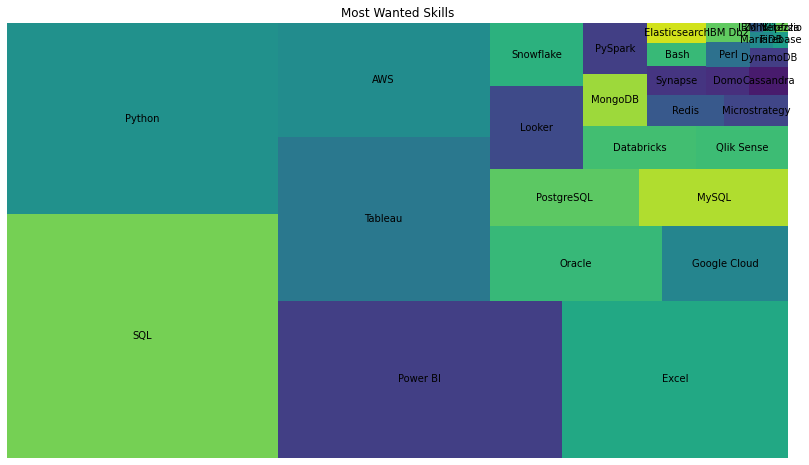

In [10]:
import matplotlib as mlp
import matplotlib.pyplot as plt
import squarify

# Add column with count of Trues for each skill
def mention_counts(x):
    return len(jobs[x].loc[jobs[x] == True])

skills["counts"] = skills["skill"].apply(mention_counts)

# Drop skills with 0 counts and sort
skills = skills.loc[skills["counts"] != 0].sort_values(by="counts", ascending=False)

# Plot
fig, axs = plt.subplots(figsize=(14,8))

squarify.plot(sizes=skills["counts"],  label=skills["skill"], text_kwargs={'fontsize':10}, ax=axs)
axs.axis('off')
axs.set(title=("Most Wanted Skills"))


[Text(0.5, 1.0, 'Most Wanted Data Warehouse Skills')]

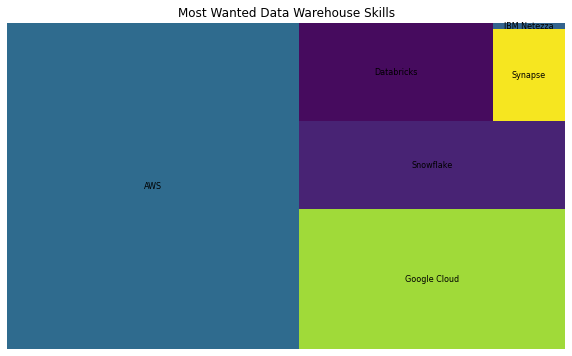

In [19]:
skill_type = "Data Warehouse"

fig, axs = plt.subplots(figsize=(10,6))

type_to_plot = skills.loc[skills["type"] == skill_type]
squarify.plot(sizes=type_to_plot["counts"],  label=type_to_plot["skill"], text_kwargs={'fontsize':8})
axs.axis('off')
axs.set(title=('Most Wanted {} Skills'.format(skill_type)))


<AxesSubplot:title={'center':'Cantidad de búsquedas por Empresa'}, ylabel='Empresa'>

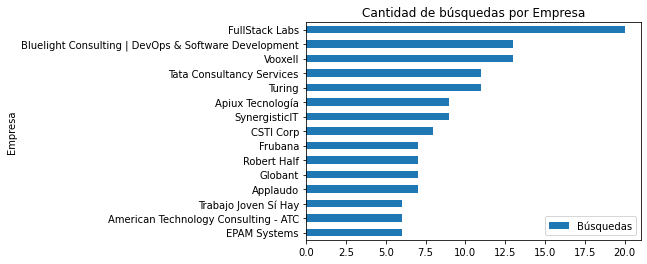

In [12]:
import matplotlib.pyplot as plt


top_companies = pd.DataFrame(jobs["company"].value_counts().sort_values(ascending=False))
top_companies.rename(columns={"company": "Búsquedas"}, inplace=True)
top_companies.reset_index(inplace=True)
top_companies.rename(columns={"index": "Empresa"}, inplace=True)
top_companies = top_companies.loc[0:14]

top_companies.sort_values("Búsquedas").plot(kind="barh", x="Empresa", title="Cantidad de búsquedas por Empresa")

<AxesSubplot:title={'center':'Cantidad de búsquedas por Sector'}, ylabel='industries'>

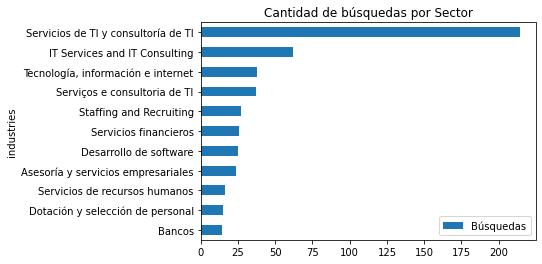

In [13]:
top_sectors = pd.DataFrame(jobs["industries"].value_counts().sort_values(ascending=False))
top_sectors.rename(columns={"industries": "Búsquedas"}, inplace=True)
top_sectors.reset_index(inplace=True)
top_sectors.rename(columns={"index":"industries"}, inplace=True)
top_sectors = top_sectors.loc[0:10]

top_sectors.sort_values("Búsquedas").plot(kind="barh", x="industries", title="Cantidad de búsquedas por Sector")

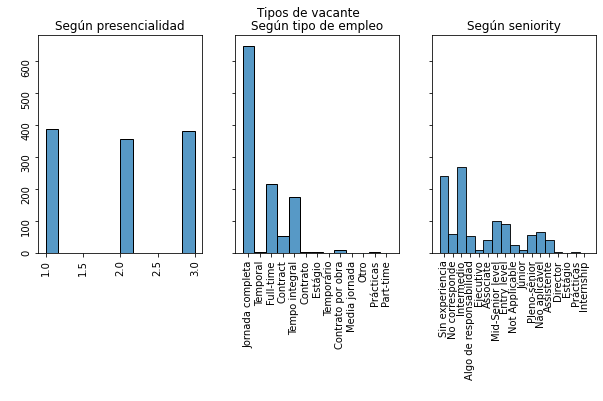

In [14]:
import seaborn as sns

fig, axs = plt.subplots(1,3, figsize=(10,4), sharey=True)

fig.suptitle("Tipos de vacante")
sns.histplot(jobs["onsite_remote"], ax=axs[0]).set(title="Según presencialidad", xlabel=" ", ylabel=" ")
sns.histplot(jobs["employment_type"], ax=axs[1]).set(title="Según tipo de empleo", xlabel=" ")
sns.histplot(jobs["seniority_level"], ax=axs[2]).set(title="Según seniority", xlabel=" ")
axs[0].tick_params(rotation=90)
axs[1].tick_params(rotation=90)
axs[2].tick_params(rotation=90)

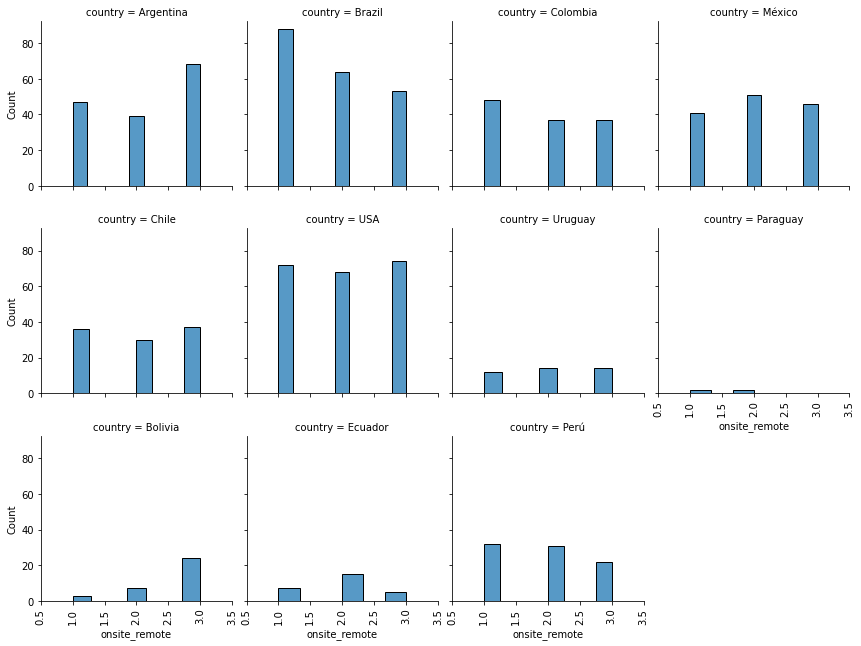

In [15]:
g = sns.FacetGrid(jobs, col="country", col_wrap=4)
g.map(sns.histplot, "onsite_remote")

g.set_xticklabels(rotation=90)